### The code for this notebook is inspired from [Orca_CNN Pre-processing](https://github.com/axiom-data-science/OrcaCNN/tree/master/PreProcessing),[WAV_FLACprocessor_Val](https://github.com/orcasound/orcadata/tree/master/WAV_FLACprocessor_Val) and [NoiseReduce](https://pypi.org/project/noisereduce/). Thank you all the authors for writing these codes.

In [1]:
import os
import csv
import librosa
import librosa.display
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import cv2
import scipy
from skimage.restoration import (denoise_wavelet, estimate_sigma)

In [2]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data - min_data) / (max_data - min_data + 1e-6)
    return data - 0.5

def mfcc(S,n_mfcc=30):
    return librosa.feature.mfcc(S=S,n_mfcc=n_mfcc)

def spectrogram(data,n_fft= 2048,fftSize= 2048,overlap= -1,window='hann',center=True):

    if window == 'hann':
        win = librosa.filters.get_window('hann',fftSize)
    else:
        raise NotImplementedError
    
    if overlap == -1:
        jump = fftSize//4
    else:
        jump = int(fftSize*(100-overlap)/overlap)
    D = librosa.stft(data,center=center,window=win,win_length=fftSize,n_fft=n_fft,hop_length=jump)
    return D

def mel_spectrogram(D,pwr=2,sr=44100):
    if pwr == 2:
        D = np.abs(D)**2
    elif pwr == 1:
        D = np.abs(D)**1
    S = librosa.feature.melspectrogram(S=D,power=pwr,sr=sr)
    return S 

def reduce_bg_noise(y):
    import noisereduce as nr
    return nr.reduce_noise(audio_clip=y, noise_clip=y, verbose=False)

def amp(K):
    return librosa.amplitude_to_db(np.abs(K),ref=np.max(K))

def pwr(K):
    return librosa.power_to_db(np.abs(K),ref=np.max(K))

def pcen(D):
    return librosa.pcen(np.abs(D))

def wavelet_denoising(data):
    
    sigma_est = estimate_sigma(data, multichannel=True, average_sigmas=True)
    im_bayes = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='BayesShrink',
                               mode='soft')
    im_visushrink = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                    mode='soft')

    # VisuShrink is designed to eliminate noise with high probability, but this
    # results in a visually over-smooth appearance. Here, we specify a reduction
    # in the threshold by factors of 2 and 4.
    im_visushrink2 = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                     mode='soft', sigma=sigma_est / 2)
    im_visushrink4 = denoise_wavelet(data, multichannel=False, convert2ycbcr=True, method='VisuShrink',
                                     mode='soft', sigma=sigma_est / 4)
    return im_bayes

def erode_and_dilate(img,kernel=np.ones((5,5), np.uint8)):
    img = img.copy()
    img = cv2.dilate(img, kernel, iterations=2) 
    img = cv2.erode(img, kernel, iterations=1)
    return img

def make_binary(img, Nsd=1):
    mean_time  = np.mean(img,axis=0,keepdims=True)
    std_time   = np.std(img,axis=0,keepdims=True)
    mean_freq  = np.mean(img,axis=-1,keepdims=True)
    std_freq   = np.std(img,axis=-1,keepdims=True)

    specBinary = np.zeros(img.shape)
    mask1 = np.logical_and(img >(mean_freq + Nsd*std_freq),img >(mean_time + Nsd*std_time))
    specBinary[mask1] = 1
    return specBinary

def contrast_enhance(img, Nsd=1):
    img    = img.copy()
    mean   = np.mean(img)
    std   = np.std(img)
    img[img>mean+Nsd*std] = mean+Nsd*std
    img[img<mean-Nsd*std] = mean-Nsd*std 
    return img

# Load Signal

In [3]:
# T = 121 # signal duration in secs
# f1 = 10
# f2 = 20
# fs = 50
# dt = 1/fs
# x = np.arange(0,T,dt)
# y = np.sin(2*np.pi*f1*x)+np.exp(1/np.cos(2*np.pi*f2*x))

#fname = librosa.util.example_audio_file()
fname  = '/data/durgesh/orca206/orca_al/data_source/FordOsbornLabeled/S_19.wav'

#fname   =  '/data/durgesh/orca206/orca_al/data_source/podcastR2_mini/1562340736_0006_0017.wav'
fs     = librosa.get_samplerate(fname)
y, fs = librosa.load(fname,fs)
x     = np.arange(0,len(y))/fs

# Plot for the Original Signal

Audio duration =0.7172562358276644 seconds,Sampling rate=44100,n_samples=31631


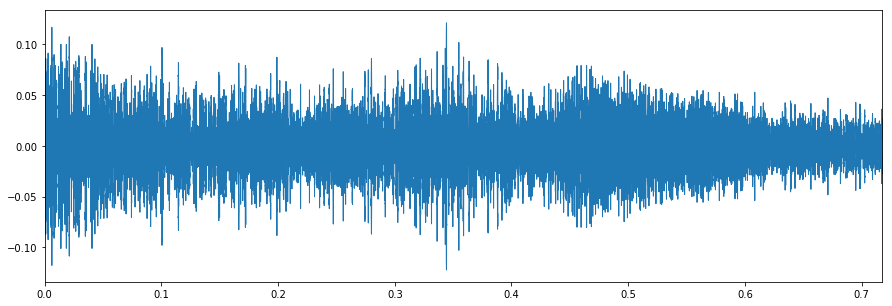

In [4]:
print('Audio duration ={} seconds,Sampling rate={},n_samples={}'.format(len(y)/fs,fs,len(y)))
plt.figure(figsize=(15,5))
_=librosa.display.waveplot(y,sr=fs,x_axis='sec')
ipd.Audio(y,rate=fs)

# Remove Background Noise

Background Noise removed Audio duration =0.7172562358276644 seconds,Sampling rate=44100,n_samples=31631


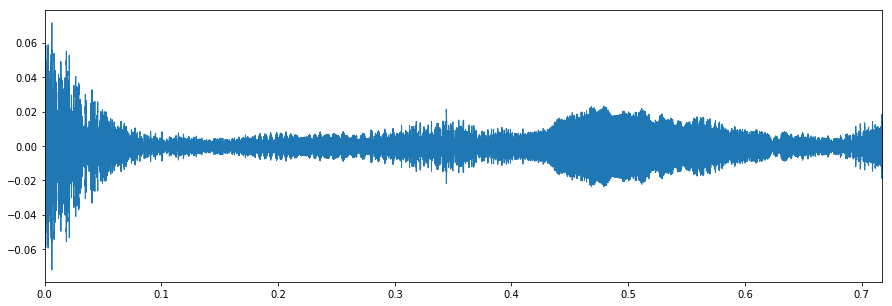

In [5]:
y = reduce_bg_noise(y)
print('Background Noise removed Audio duration ={} seconds,Sampling rate={},n_samples={}'.format(len(y)/fs,fs,len(y)))
plt.figure(figsize=(15,5))
_=librosa.display.waveplot(y,sr=fs,x_axis='sec')
ipd.Audio(y,rate=fs)

# Normalize Audio

Normalized Audio duration =0.7172562358276644 seconds,Sampling rate=44100,n_samples=31631


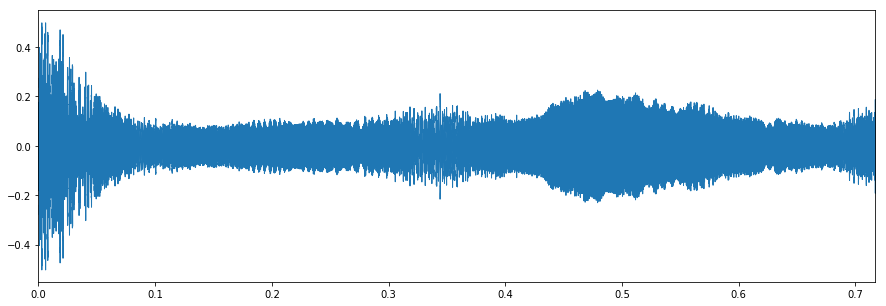

In [6]:
y = audio_norm(y)
print('Normalized Audio duration ={} seconds,Sampling rate={},n_samples={}'.format(len(y)/fs,fs,len(y)))
plt.figure(figsize=(15,5))
_=librosa.display.waveplot(y,sr=fs,x_axis='sec')
ipd.Audio(y,rate=fs)

# Spectrogram creation

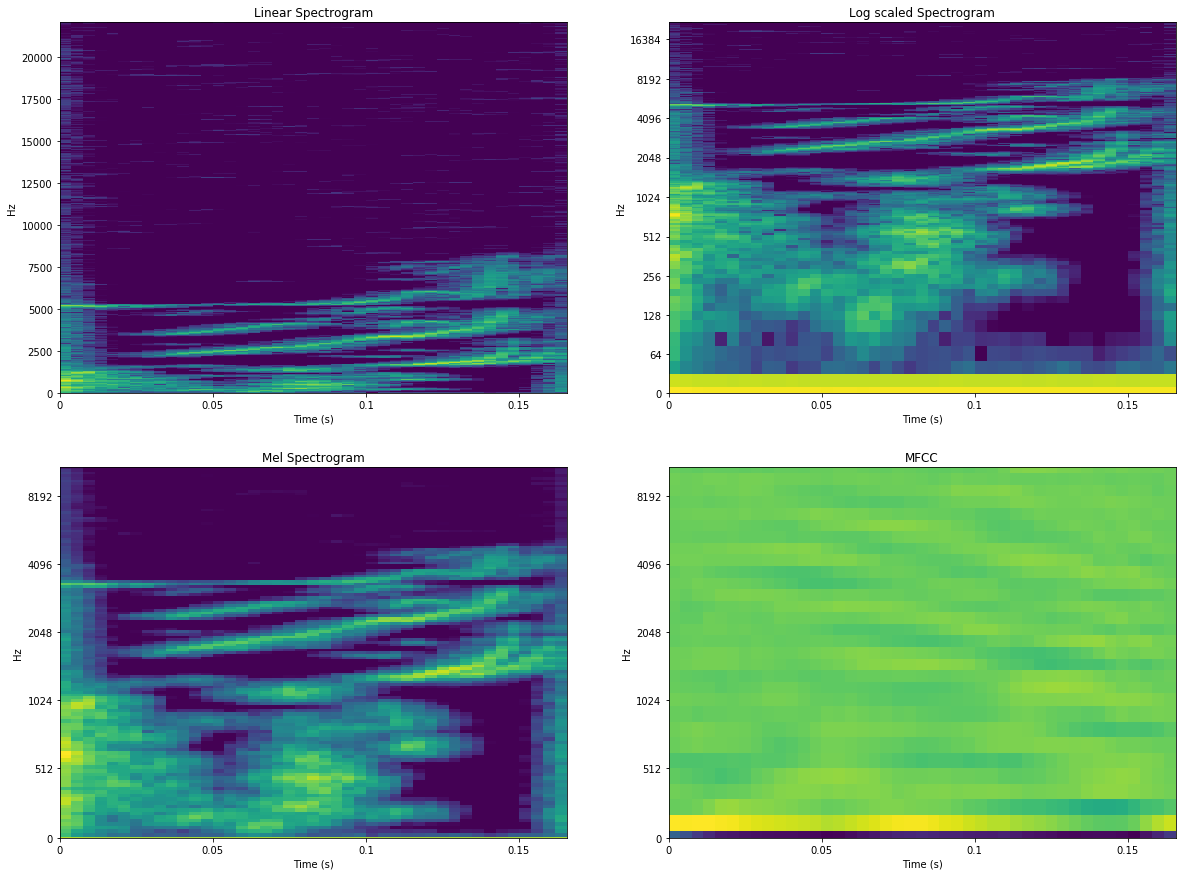

In [7]:
n_fft      = 2048 # frequency range in (Hz) in each FFT block
fftSize    = 512 # block length (samples)
overlap    = 75  # percentage overlap in two consecutive blocks
window     = librosa.filters.get_window('hann',fftSize)  # custom filter function 
jump       = int(fftSize*(100-overlap)/overlap)

D     = spectrogram(y,center=False,overlap=75)
D_amp = amp(D)
S     = mel_spectrogram(D=D,pwr=1,sr=fs)
S_amp = amp(S)
M = mfcc(S_amp)


fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,15))
ax1.title.set_text('Linear Spectrogram')
ax2.title.set_text('Log scaled Spectrogram')
ax3.title.set_text('Mel Spectrogram')
ax4.title.set_text('MFCC')
_=librosa.display.specshow(D_amp,cmap='viridis',y_axis='linear',x_coords=np.arange(D.shape[1])*jump/fs,x_axis='s',sr=fs,ax=ax1)
_=librosa.display.specshow(D_amp,cmap='viridis',y_axis='log',x_coords=np.arange(D.shape[1])*jump/fs,x_axis='s',sr=fs,ax=ax2)
_=librosa.display.specshow(S_amp,y_axis='mel',cmap='viridis',x_coords=np.arange(S_amp.shape[1])*jump/fs,x_axis='s',sr=fs,ax=ax3)
_=librosa.display.specshow(M,y_axis='mel',x_axis='s',sr=fs,x_coords=np.arange(S_amp.shape[1])*jump/fs,ax=ax4,cmap='viridis')

## Erosion and Dilation

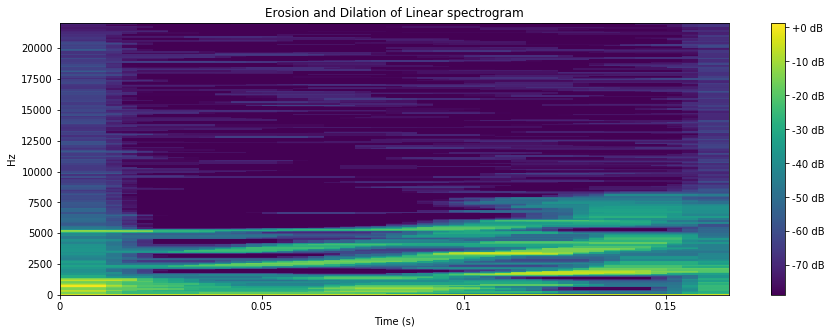

In [8]:
kernel  = np.ones((5,5), np.uint8) 
D_amp_1 = erode_and_dilate(D_amp,kernel)
plt.figure(figsize=(15,5))
plt.title('Erosion and Dilation of Linear spectrogram')
librosa.display.specshow(D_amp_1,y_axis='linear',cmap='viridis',x_coords=np.arange(D_amp_1.shape[1])*jump/fs,x_axis='s',sr=fs)
_=plt.colorbar(format='%+2.0f dB')

## Binarization

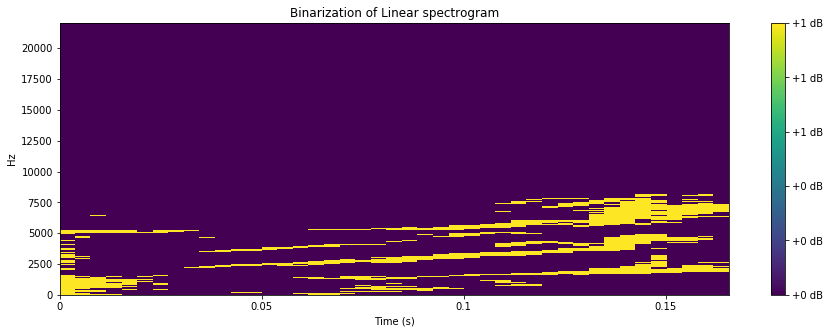

In [9]:
D_amp_1 = amp(spectrogram(y,center=False,overlap=75))
D_amp_1 = make_binary(D_amp,Nsd=1)
plt.figure(figsize=(15,5))
plt.title('Binarization of Linear spectrogram')
_=librosa.display.specshow(D_amp_1,y_axis='linear',cmap='viridis',x_coords=np.arange(D_amp_1.shape[1])*jump/fs,x_axis='s',sr=fs)
_=plt.colorbar(format='%+2.0f dB')

# Contrast Enhancement of Spectrogram

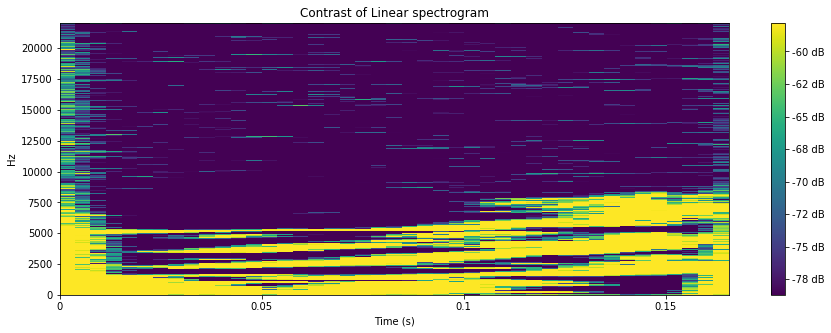

In [10]:
D_amp_1 = amp(spectrogram(y,center=False,overlap=75))
D_amp_1  =contrast_enhance(D_amp_1,Nsd=1)
plt.figure(figsize=(15,5))
plt.title('Contrast of Linear spectrogram')
_=librosa.display.specshow(D_amp_1,cmap='viridis',y_axis='linear',x_coords=np.arange(D_amp_1.shape[1])*jump/fs,x_axis='s',sr=fs)
_=plt.colorbar(format='%+2.0f dB')

# Method-1 Spectrogram Complete Processing 
Given spectrogram we can perform following steps as post processing steps to enhance the quality of spectrogram-
1. Get Linear Spectrogram
2. Erosion(2 iterations) and Dilation
3. Binarization 

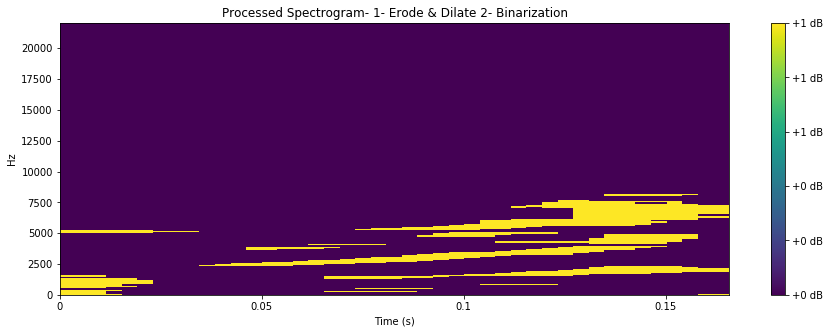

In [11]:
D_amp_1 = amp(spectrogram(y,center=False,overlap=75))
D_amp_1 = erode_and_dilate(D_amp_1)
D_amp_1 = make_binary(D_amp_1,1)
plt.figure(figsize=(15,5))
plt.title('Processed Spectrogram- 1- Erode & Dilate 2- Binarization')
_=librosa.display.specshow(D_amp_1,cmap='viridis',y_axis='linear',x_coords=np.arange(D_amp_1.shape[1])*jump/fs,x_axis='s',sr=fs)
_=plt.colorbar(format='%+2.0f dB')

# Method 2 - Spectrogram Complete Processing 
Given spectrogram we can perform following steps as post processing steps to enhance the quality of spectrogram-
1. Get Linear Spectrogram
2. Erosion(2 iterations) and Dilation
3. Contrast Enhancement 

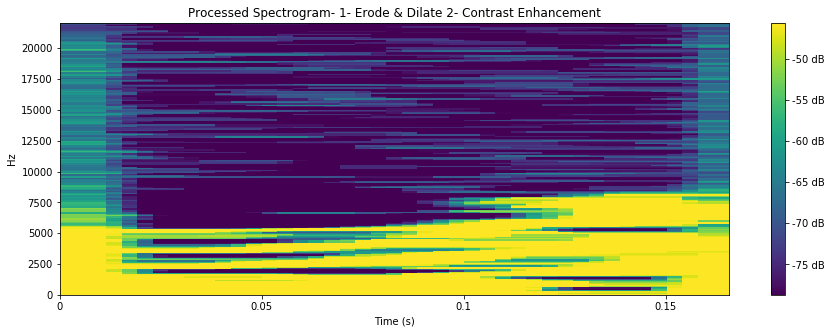

In [12]:
D_amp_1 = amp(spectrogram(y,center=False,overlap=75))
D_amp_1 = erode_and_dilate(D_amp_1)
D_amp_1 = contrast_enhance(D_amp_1)
plt.figure(figsize=(15,5))
plt.title('Processed Spectrogram- 1- Erode & Dilate 2- Contrast Enhancement')
_=librosa.display.specshow(D_amp_1,cmap='viridis',y_axis='linear',x_coords=np.arange(D_amp_1.shape[1])*jump/fs,x_axis='s',sr=fs)
_=plt.colorbar(format='%+2.0f dB')

# Method 3 - Spectrogram Complete Processing 
Given spectrogram we can perform following steps as post processing steps to enhance the quality of spectrogram-
1. Get Linear Spectrogram
2. Apply PCEN
3. Wavelet Denoising

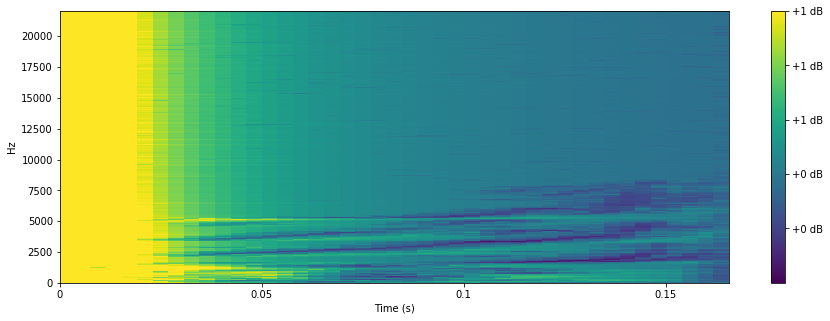

In [13]:
D            = spectrogram(y,center=False,overlap=75)
D_amp        = amp(D)
pcen_D       = pcen(D_amp)
res          = wavelet_denoising(pcen_D)
plt.figure(figsize=(15,5))
_=librosa.display.specshow(res,cmap='viridis',y_axis='linear',x_coords=np.arange(res.shape[1])*jump/fs,x_axis='s',sr=fs)
_=plt.colorbar(format='%+2.0f dB')

# Method 4 - Spectrogram Complete Processing 
Given spectrogram we can perform following steps as post processing steps to enhance the quality of spectrogram-
1. Linar Spectrogram
2. Mel Spectrogram
2. Apply PCEN
3. Wavelet Denoising

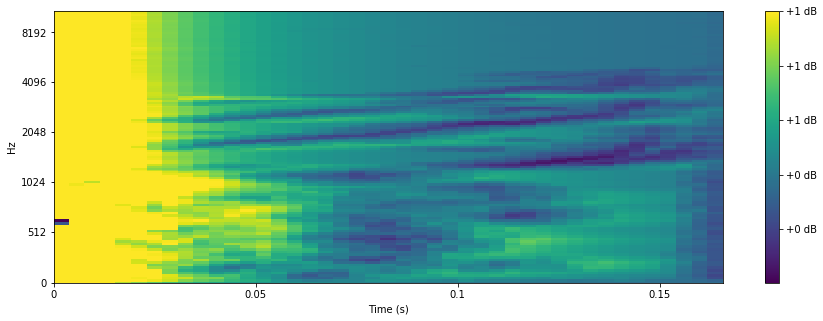

In [14]:
D            = spectrogram(y,center=False,overlap=75)
S            = mel_spectrogram(D=D,sr=fs,pwr=1)
S_amp        = amp(S)
pcen_D       = pcen(S_amp)
res          = wavelet_denoising(pcen_D)
plt.figure(figsize=(15,5))
_=librosa.display.specshow(res,cmap='viridis',y_axis='mel',x_coords=np.arange(res.shape[1])*jump/fs,x_axis='s',sr=fs)
_=plt.colorbar(format='%+2.0f dB')